In [1]:
from keras import utils
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
#定义网络结构
def CNN_model(size):
    input_data = Input(size)
    
    x = Conv2D(32, (3, 3), activation='relu')(input_data)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (2, 2), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (2, 2), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024,activation='relu')(x)
    output = Dense(30)(x)
    return Model(inputs=input_data, outputs=output, name='Discriminator')

model=CNN_model((96, 96, 1))
optimizer = SGD(lr=0.03, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=optimizer)
epoch_num = 1000
learning_rate = np.linspace(0.03, 0.01, epoch_num)
change_lr = LearningRateScheduler(lambda epoch: float(learning_rate[epoch]))
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
check_point= ModelCheckpoint('CNN_model_final.h5', monitor='val_loss',verbose=0,save_best_only=True,save_weights_only=False, mode='auto', period=1)

Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#读取数据
import pandas as pd
import numpy as np
label_path='train_kp.csv'
kp_df=pd.read_csv(label_path)
kp_df.head(10)

#去掉NAN的行
kp_df.dropna(axis=0, how='any', inplace=True)
print(kp_df.shape)
kp_df.head()

train_path='dataset/train/'
data_list=list(map(lambda x:train_path+str(x)+'.jpg',kp_df.index))
print(data_list[0:5])
labels=kp_df.values
print(labels[0:3,:])

#shuffle
index=np.arange(len(data_list))
np.random.seed(2018)
np.random.shuffle(index)
data_list=np.array(data_list)
data_list=data_list[index]
labels=labels[index,:]
print('after shuffle:')
print(data_list[0:5])
print(labels[0:3,:])

#split train/val
train_list=data_list[0:int(len(data_list)*0.8)]
train_labels=labels[0:int(len(data_list)*0.8),:]
val_list=data_list[int(len(data_list)*0.8):]
val_labels=labels[int(len(data_list)*0.8):,:]
print('train_labels:',train_labels.shape)
print('val_labels:',val_labels.shape)

(2140, 30)
['dataset/train/0.jpg', 'dataset/train/1.jpg', 'dataset/train/2.jpg', 'dataset/train/3.jpg', 'dataset/train/4.jpg']
[[ 66.03356391  39.00227368  30.22700752  36.4216782   59.58207519
   39.64742256  73.13034586  39.96999699  36.35657143  37.3894015
   23.45287218  37.3894015   56.95326316  29.03364812  80.22712782
   32.22813835  40.22760902  29.0023218   16.35637895  29.64747068
   44.42057143  57.06680301  61.19530827  79.97016541  28.61449624
   77.38899248  43.3126015   72.93545865  43.13070677  84.48577444]
 [ 64.33293617  34.9700766   29.9492766   33.44871489  58.85617021
   35.27434894  70.7227234   36.18716596  36.0347234   34.36153191
   24.47251064  33.14444255  53.98740426  28.27594894  78.63421277
   30.4059234   42.72885106  26.14604255  16.8653617   27.05885957
   48.20629787  55.66093617  56.42144681  76.352       35.12238298
   76.04765957  46.68459574  70.26655319  45.46791489  85.48017021]
 [ 65.05705263  34.90964211  30.90378947  34.90964211  59.412       

In [17]:
from skimage import io
#生成器generator
def generate_for_kp(file_list, label_list, batch_size):
    while True:
        count = 0
        x, y = [], []
        for i,path in enumerate(file_list):
            img=io.imread(path)
            img = np.array(img)
            x_temp=img/255.0
            y_temp=(label_list[i,:]-48.0)/48.0
            count += 1
            x.append(x_temp)
            y.append(y_temp)
            if count % batch_size == 0 and count != 0:
                x = np.array(x)
                x = x.reshape(batch_size, 96, 96, 1).astype("float32")
                y = np.array(y)
                yield x, y
                x, y = [], []
                
def generate_for_kp_test(file_list, batch_size):
    while True:
        count = 0
        x= []
        for path in file_list:
            img=io.imread(path)
            img = np.array(img)
            x_temp=img/255.0
            count += 1
            x.append(x_temp)
            if count % batch_size == 0 and count != 0:
                x = np.array(x)
                x = x.reshape(batch_size, 96, 96, 1).astype("float32")
                yield x
                x = []

In [12]:
model.fit_generator(generate_for_kp(train_list,train_labels,64),steps_per_epoch=int(len(train_list)/64)+1,\
                    epochs=epoch_num,verbose=1,validation_data=generate_for_kp(val_list,val_labels,64),\
                    validation_steps=int(len(val_list)/64)+1,\
                    callbacks=[change_lr,early_stop,check_point])

Epoch 1/100
27/27 [==============================] - 2s 57ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 2/100
27/27 [==============================] - 1s 30ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 3/100
27/27 [==============================] - 1s 47ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/100
27/27 [==============================] - 1s 32ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/100
27/27 [==============================] - 1s 30ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/100
27/27 [==============================] - 1s 48ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/100
27/27 [==============================] - 1s 31ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/100
27/27 [==============================] - 1s 32ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 9/100
27/27 [==============================] - 1s 48ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/100
27/27 [==============================] - 1s 33ms/step - loss: 0.0025 - val_loss: 0.0025

training results:


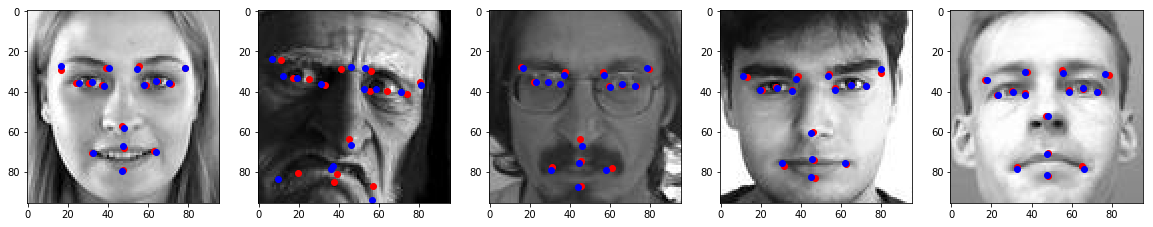

In [11]:
import matplotlib.pyplot as plt
from skimage import io
np.random.seed(2018)
#trainset predict step
model.load_weights('CNN_model_final.h5')
test_list=np.array(list(map(lambda x:'dataset/test/'+str(x),os.listdir('dataset/test/'))))
train_index=np.arange(len(train_list))
val_index=np.arange(len(val_list))
test_index=np.arange(len(test_list))
np.random.shuffle(train_index)
np.random.shuffle(val_index)
np.random.shuffle(test_index)
train_index=train_index[0:5]
val_index=val_index[0:5]
test_index=test_index[0:5]
train_predict=train_list[train_index]
val_predict=val_list[val_index]
test_predict=test_list[test_index]
train_label_predict=train_labels[train_index]
val_label_predict=val_labels[val_index]

train_img=[]
val_img=[]
test_img=[]
for t in train_predict:
    train_img.append(io.imread(t)/255.)
for t in val_predict:
    val_img.append(io.imread(t)/255.)
for t in test_predict:
    test_img.append(io.imread(t)/255.)

#draw train results
print('training results:')
plt.figure(figsize=(20,20)) 
for i,t in enumerate(train_img):
    prediction=model.predict(t.reshape(1, 96, 96, 1))[0]
    prediction=prediction*48.0+48.0
    x_list=prediction[np.arange(0,29,2)]
    y_list=prediction[np.arange(1,30,2)]
    x_list_real=train_label_predict[i][np.arange(0,29,2)]
    y_list_real=train_label_predict[i][np.arange(1,30,2)]
    
    plt.subplot(1,5,i+1)
    plt.imshow(t,cmap=plt.cm.gray)
    plt.scatter(x_list,y_list,c='r')
    plt.scatter(x_list_real,y_list_real,c='b')
plt.show()
    

validation results:


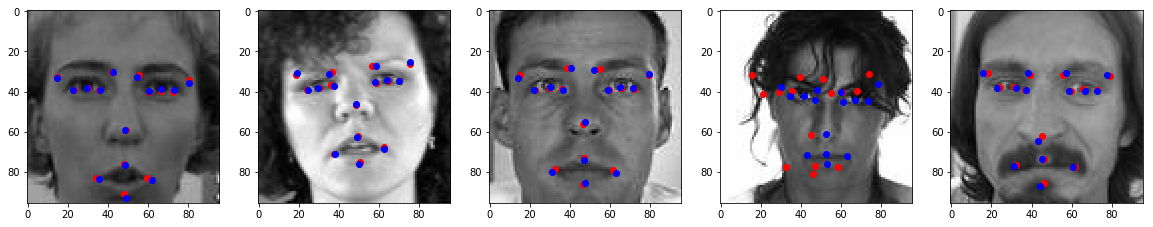

In [12]:
#draw val results
print('validation results:')
plt.figure(figsize=(20,20)) 
for i,t in enumerate(val_img):
    prediction=model.predict(t.reshape(1, 96, 96, 1))[0]
    prediction=prediction*48.0+48.0
    x_list=prediction[np.arange(0,29,2)]
    y_list=prediction[np.arange(1,30,2)]
    x_list_real=val_label_predict[i][np.arange(0,29,2)]
    y_list_real=val_label_predict[i][np.arange(1,30,2)]
    
    plt.subplot(1,5,i+1)
    plt.imshow(t,cmap=plt.cm.gray)
    plt.scatter(x_list,y_list,c='r')
    plt.scatter(x_list_real,y_list_real,c='b')
plt.show()    

test results:


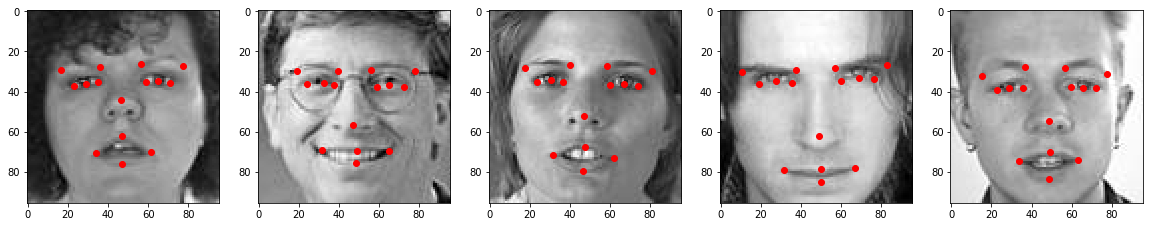

In [13]:
#draw test results
print('test results:')
plt.figure(figsize=(20,20)) 
for i,t in enumerate(test_img):
    prediction=model.predict(t.reshape(1, 96, 96, 1))[0]
    prediction=prediction*48.0+48.0
    x_list=prediction[np.arange(0,29,2)]
    y_list=prediction[np.arange(1,30,2)]
    
    plt.subplot(1,5,i+1)
    plt.imshow(t,cmap=plt.cm.gray)
    plt.scatter(x_list,y_list,c='r')
plt.show()    

In [18]:
#对test进行预测
import matplotlib.pyplot as plt
from skimage import io
np.random.seed(2018)
#trainset predict step
model.load_weights('CNN_model_final.h5')
test_list=np.arange(1,1784)
test_list=list(map(lambda x:'dataset/test/'+str(x)+'.jpg',test_list))
result=model.predict_generator(generate_for_kp_test(test_list,64),steps=int(len(test_list)/64)+1,verbose=1)
result=result*48+48
print(result.shape)

28/28 [==============================] - 5s 191ms/step
(1792, 30)
